<a href="https://colab.research.google.com/github/ekmungi/ml_examples/blob/master/pytorch_cnn_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader

In [0]:
composed = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.ToTensor()])

In [0]:
train_dataset = dsets.FashionMNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.FashionMNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [0]:
batch_size = 100

In [0]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
print(len(train_loader))
for image, label in train_loader:
    print(image.shape, label.shape, image[0,0,:,:].max())
    break

600
torch.Size([100, 1, 28, 28]) torch.Size([100]) tensor(1.)


In [0]:
class GlobalMaxPool2D(nn.Module):
    '''
    Reduce to feature space
    '''
    def __init__(self):
        super(GlobalMaxPool2D, self).__init__()
        
    def forward(self, x):
        x =  torch.max(torch.max(x, 3, keepdim=False)[0], 2, keepdim=False)[0]
        return x


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)

class CNNModel(nn.Module):
    def __init__(self, n_classes, debug=False):
        super(CNNModel, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        # self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.global_maxpool = GlobalMaxPool2D()
        self.fc1 = nn.Linear(in_features=800, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dropout2d = nn.Dropout2d()
        self.dropout = nn.Dropout()
        self.flatten = Flatten()
        

        self.debug = debug
        
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        if self.debug:
            print(x.shape)
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.dropout2d(x)
        if self.debug:
            print(x.shape)
        # x = self.maxpool(self.relu(self.conv3(x)))
        # if self.debug:
        #     print(x.shape)
        
        # x = self.global_maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        if self.debug:
            print(x.shape)

        
        
        x = self.fc1(x)
        x = self.dropout(x)
        if self.debug:
            print(x.shape)
        x = self.fc2(x)
        if self.debug:
            print(x.shape)

        
        return x
            
        
        

0 : 0.6829680800437927, 76
1 : 0.7459284067153931, 78
2 : 0.5706508755683899, 81
3 : 0.5170120596885681, 82
4 : 0.6352803707122803, 83
5 : 0.5464844107627869, 84
6 : 0.7018163800239563, 84
7 : 0.5211969017982483, 85
8 : 0.5567182898521423, 85
9 : 0.5370659232139587, 85
10 : 0.3686281442642212, 86
11 : 0.3687348961830139, 86
12 : 0.5796474814414978, 86
13 : 0.48154282569885254, 86
14 : 0.445369154214859, 86
15 : 0.5209728479385376, 86
16 : 0.5193297863006592, 86
17 : 0.3903774917125702, 86
18 : 0.32219481468200684, 86
19 : 0.5011651515960693, 86
20 : 0.4639284610748291, 86
21 : 0.4439605474472046, 86
22 : 0.5187378525733948, 87
23 : 0.4747912585735321, 87
24 : 0.4506872594356537, 87
25 : 0.5138410329818726, 86
26 : 0.3481023907661438, 86
27 : 0.4614514112472534, 87
28 : 0.32390570640563965, 87
29 : 0.3452293276786804, 87
30 : 0.5553795695304871, 87
31 : 0.47971129417419434, 87
32 : 0.5017114877700806, 87
33 : 0.38179659843444824, 87
34 : 0.33343973755836487, 88
35 : 0.38791972398757935,

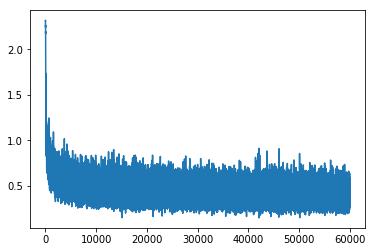

In [0]:
num_epochs = 100
learning_rate = 0.01

n_classes = 10

model = CNNModel(n_classes, debug=False)


loss_list = []

if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
    model.train()
    for iteration, (image, label) in enumerate(train_loader):


        if torch.cuda.is_available():
            X = image.cuda()
            y = label.cuda()
        else:
            X = image
            y = label


        optimizer.zero_grad()

        y_pred = model(X)
        # break
                
        loss = criterion(y_pred, y)
        
        loss.backward()
        
        optimizer.step()

        loss_list.append(loss.cpu().data)

    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for iteration, (image, label) in enumerate(test_loader):
            if torch.cuda.is_available():
                X = image.cuda()
                y = label.cuda()
            else:
                X = image
                y = label

            y_pred = model(X)

            _, predicted = torch.max(y_pred.data, 1)

            total += y.size(0)

            if torch.cuda.is_available():
                correct += (predicted.cpu() == y.cpu()).sum()
            else:
                correct += (predicted == y).sum()

        print("{0} : {1}, {2}".format(epoch, loss.cpu().data, np.round(100*correct/total, 2)))


        

plt.plot(np.arange(0,len(loss_list)), np.array(loss_list))
